# 05 - Song Lyrics Exploratory Data Analysis

In [34]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

sns.set(context='poster', style='white')
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data

In [24]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

artist_all     artist_base  rank  \
4234  ja rule  featuring  ashanti         ja rule    25   
2557                 cyndi lauper    cyndi lauper    65   
2176               john schneider  john schneider    82   

                       song  year artist_featured             song_clean  \
4234              mesmerize  2003         ashanti              mesmerize   
2557  all through the night  1985             NaN  all through the night   
2176      it's now or never  1981             NaN       its now or never   

        artist_clean                                             lyrics  \
4234         ja rule   haha yeah whattup ma how you been yeah i know...   
2557    cyndi lauper   all through the night ill be awake and ill be...   
2176  john schneider  its now or never come hold me tight kiss me my...   

      acousticness    ...      speechiness   tempo  time_signature  valence  \
4234        0.0554    ...           0.2090  90.089             4.0    0.368   
2557        0.2010    ...           0.0257  95.100             4.0    0.346   
2176           NaN    ...              NaN     NaN             NaN      NaN   

      duration_min  num_words  words_per_sec  num_uniq_words  decade  \
4234      4.645333      468.0       1.679104           200.0    2000   
2557      4.547333      237.0       0.868641            74.0    1980   
2176           NaN      156.0            NaN            79.0    1980   

     uniq_ratio  
4234   2.340000  
2557   3.202703  
2176   1.974684  

[3 rows x 30 columns]

## Word2Vec 

In [26]:
# generate distributed representations of tokens that appear more than twice
min_count = 2
lyrics = df['lyrics'].dropna().values.tolist()
lyrics_tokenized = [lyric.split() for lyric in lyrics]
model = Word2Vec(lyrics_tokenized, size=50, min_count=min_count, window=5)

# create a list of tokens sorted by their frequency
count = CountVectorizer(stop_words='english')
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)
mask = freqs >= min_count
indices = np.argsort(-freqs).squeeze().tolist()
freqs_filtered = freqs[indices]
words_sorted = np.array(count.get_feature_names())[indices]

# project the word embeddings of top n_words_display words down to 2 dimensions
n_words_display = 200
X = model[words_sorted[:n_words_display]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [302]:
# print most similar words to query_words
query_words = ['you', 'love', 'dance', 'oh', 'money']
similar_words = [[res[0] for res in model.wv.most_similar(qw)] \
                         for qw in query_words]
for word in query_words:
    print('|{:^15}|'.format(word), end='')
print()
print('=' * 85)
for i in range(10):
    for j in range(5):
        print('|{:^15}|'.format(similar_words[j][i]), end='')
    print()

|      you      ||     love      ||     dance     ||      oh       ||     money     |
|       i       ||     baby      ||    boogie     ||     whoa      ||     dough     |
|      me       ||     true      ||     roll      ||      yes      ||     cash      |
|     baby      ||    loving     ||     floor     ||     lord      ||    bitches    |
|      if       ||    believe    ||      do       ||     yeah      ||    niggas     |
|   anything    ||      me       ||     move      ||     baby      ||     shit      |
|    really     ||    because    ||     ride      ||     woah      ||     price     |
|     just      ||      you      ||   embracing   ||    craving    ||    chicks     |
|     girl      ||     kiss      ||     loco      ||    darling    ||    respect    |
|      it       ||     heart     ||    dancing    ||     dear      ||      pay      |
|  everything   ||     life      ||      get      ||    darlin     ||     nigga     |


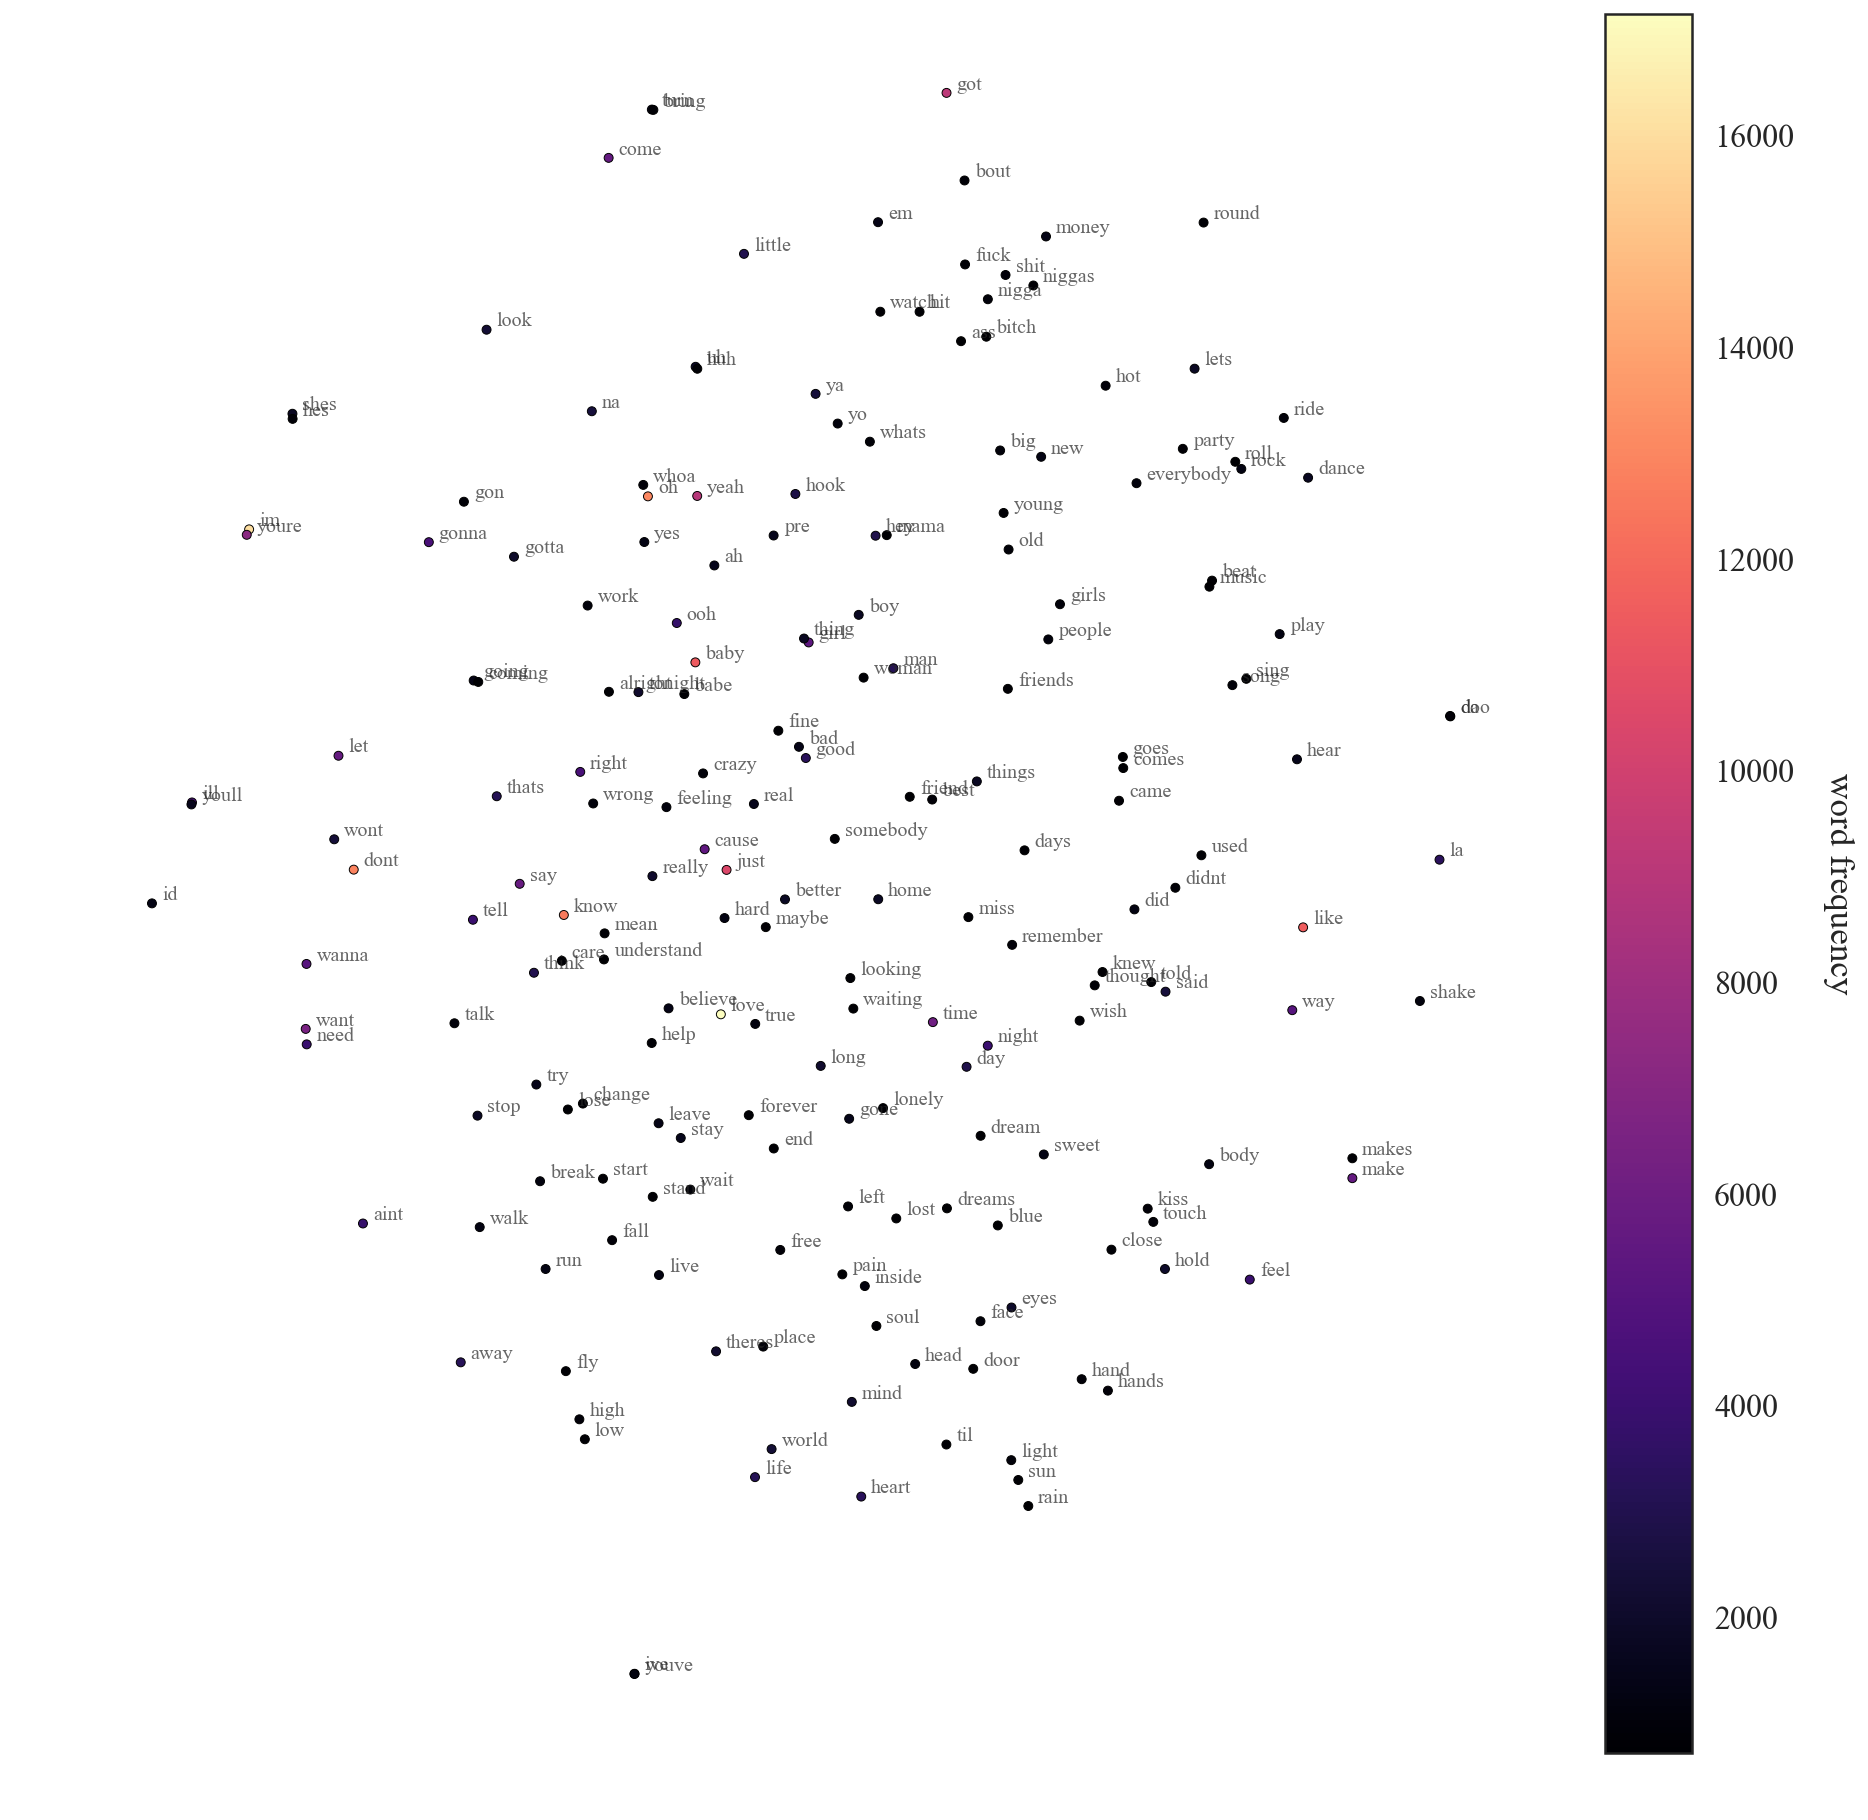

In [275]:
# plot 2D projections of top n_words_display words
plt.figure(figsize=(16,16))
ax = plt.gca()
cb = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=20, c=freqs_filtered[:n_words_display],
                cmap='magma', edgecolor='black')
cb = plt.colorbar(cb)
cb.set_label('word frequency', rotation=270, labelpad=30)
ax.axis('off')

# annotate each point
for index, word in enumerate(words_sorted[:n_words_display]):
    xy = X_tsne[index]
    ax.annotate(word, xy=xy, xytext=(5,2), textcoords='offset points',
                 alpha=0.7)

## Most popular words 

In [25]:
# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

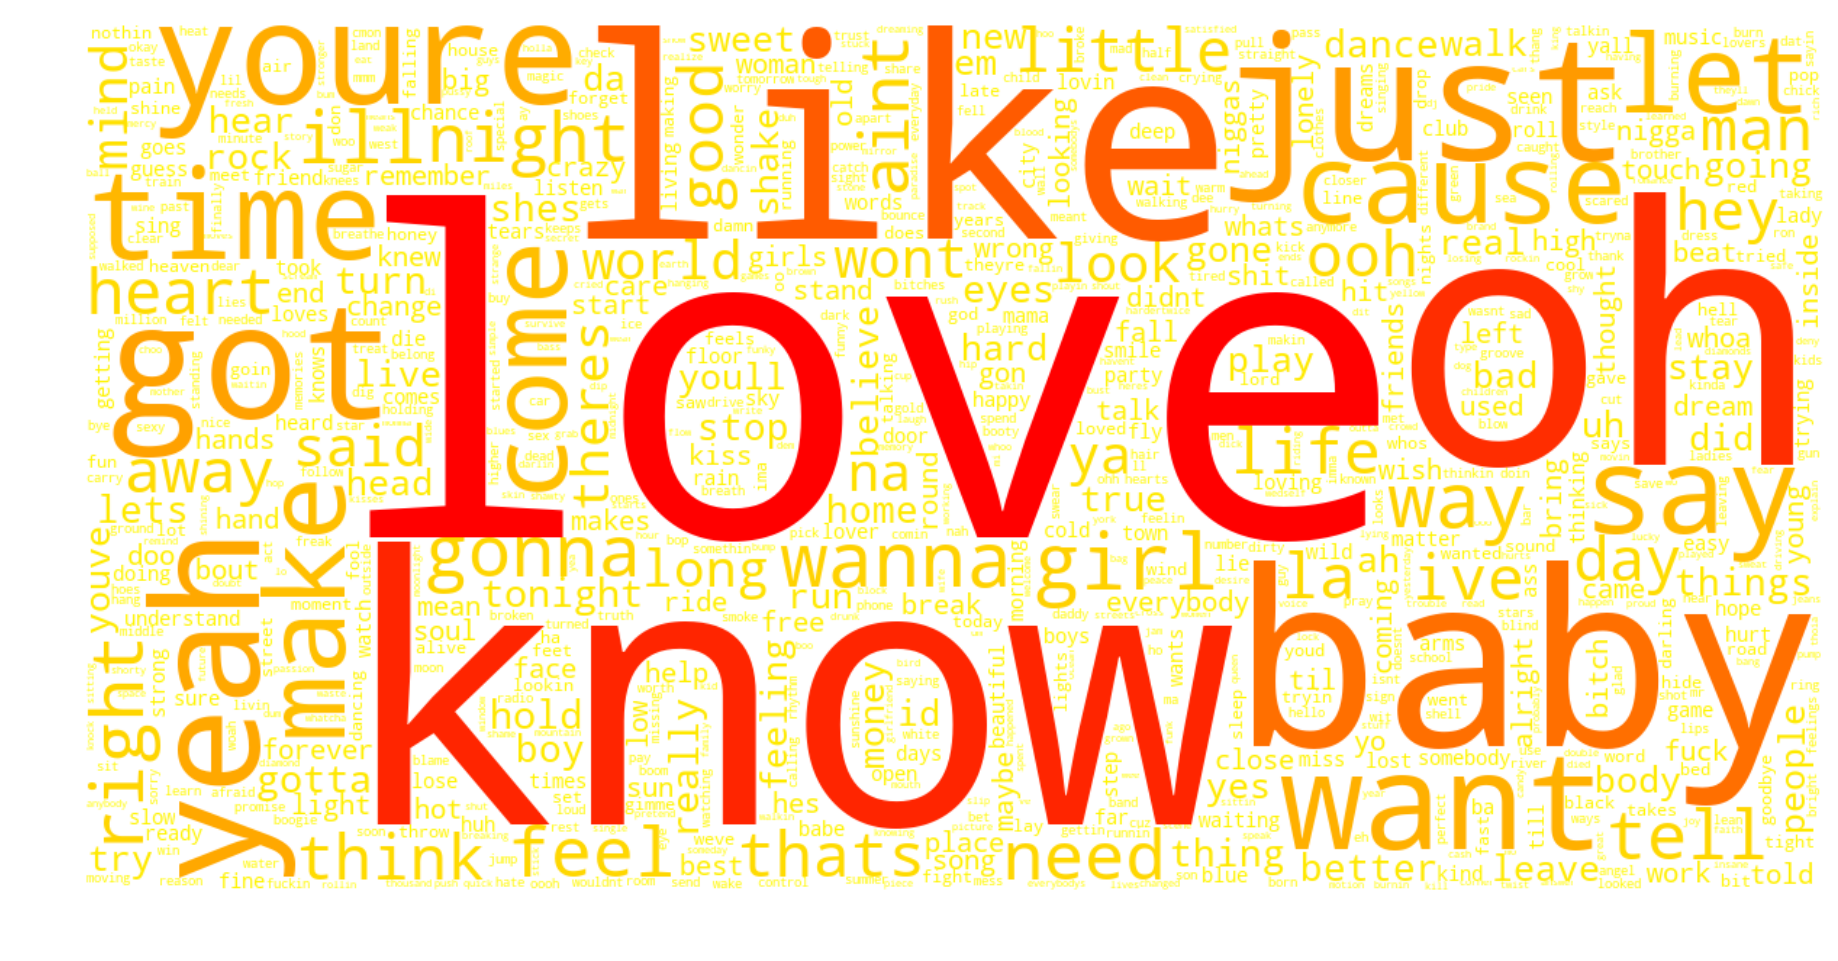

In [42]:
# calculate word frequencies
stop_words = list(ENGLISH_STOP_WORDS) + ['im', 'dont']
count = CountVectorizer(stop_words=stop_words)
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count.get_feature_names(), freqs))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('autumn_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');

## Most popular bigrams

(-0.5, 1199.5, 599.5, -0.5)

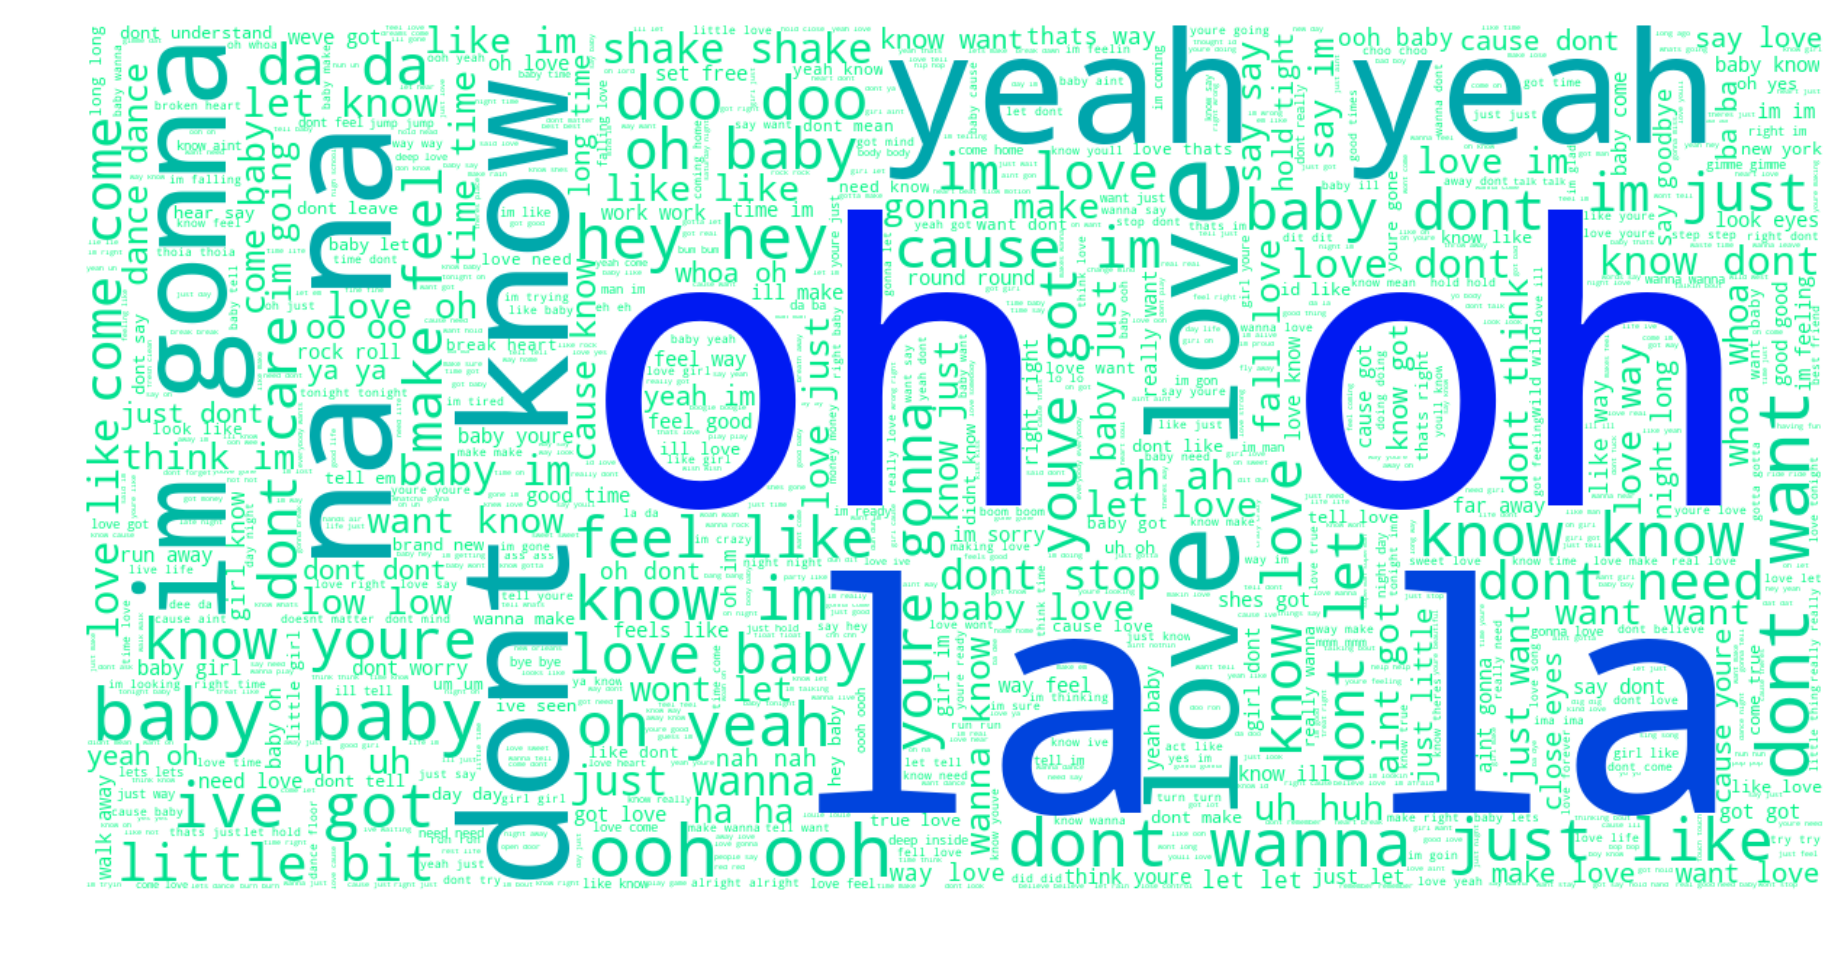

In [43]:
# calculate bigram frequencies
count_bigrams = CountVectorizer(stop_words='english', ngram_range=(2,2))
count_bigrams.fit(lyrics)
freq_bigrams = np.array(
    count_bigrams.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count_bigrams.get_feature_names(), freq_bigrams))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('winter_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');

# Latent Dirichlet Allocation

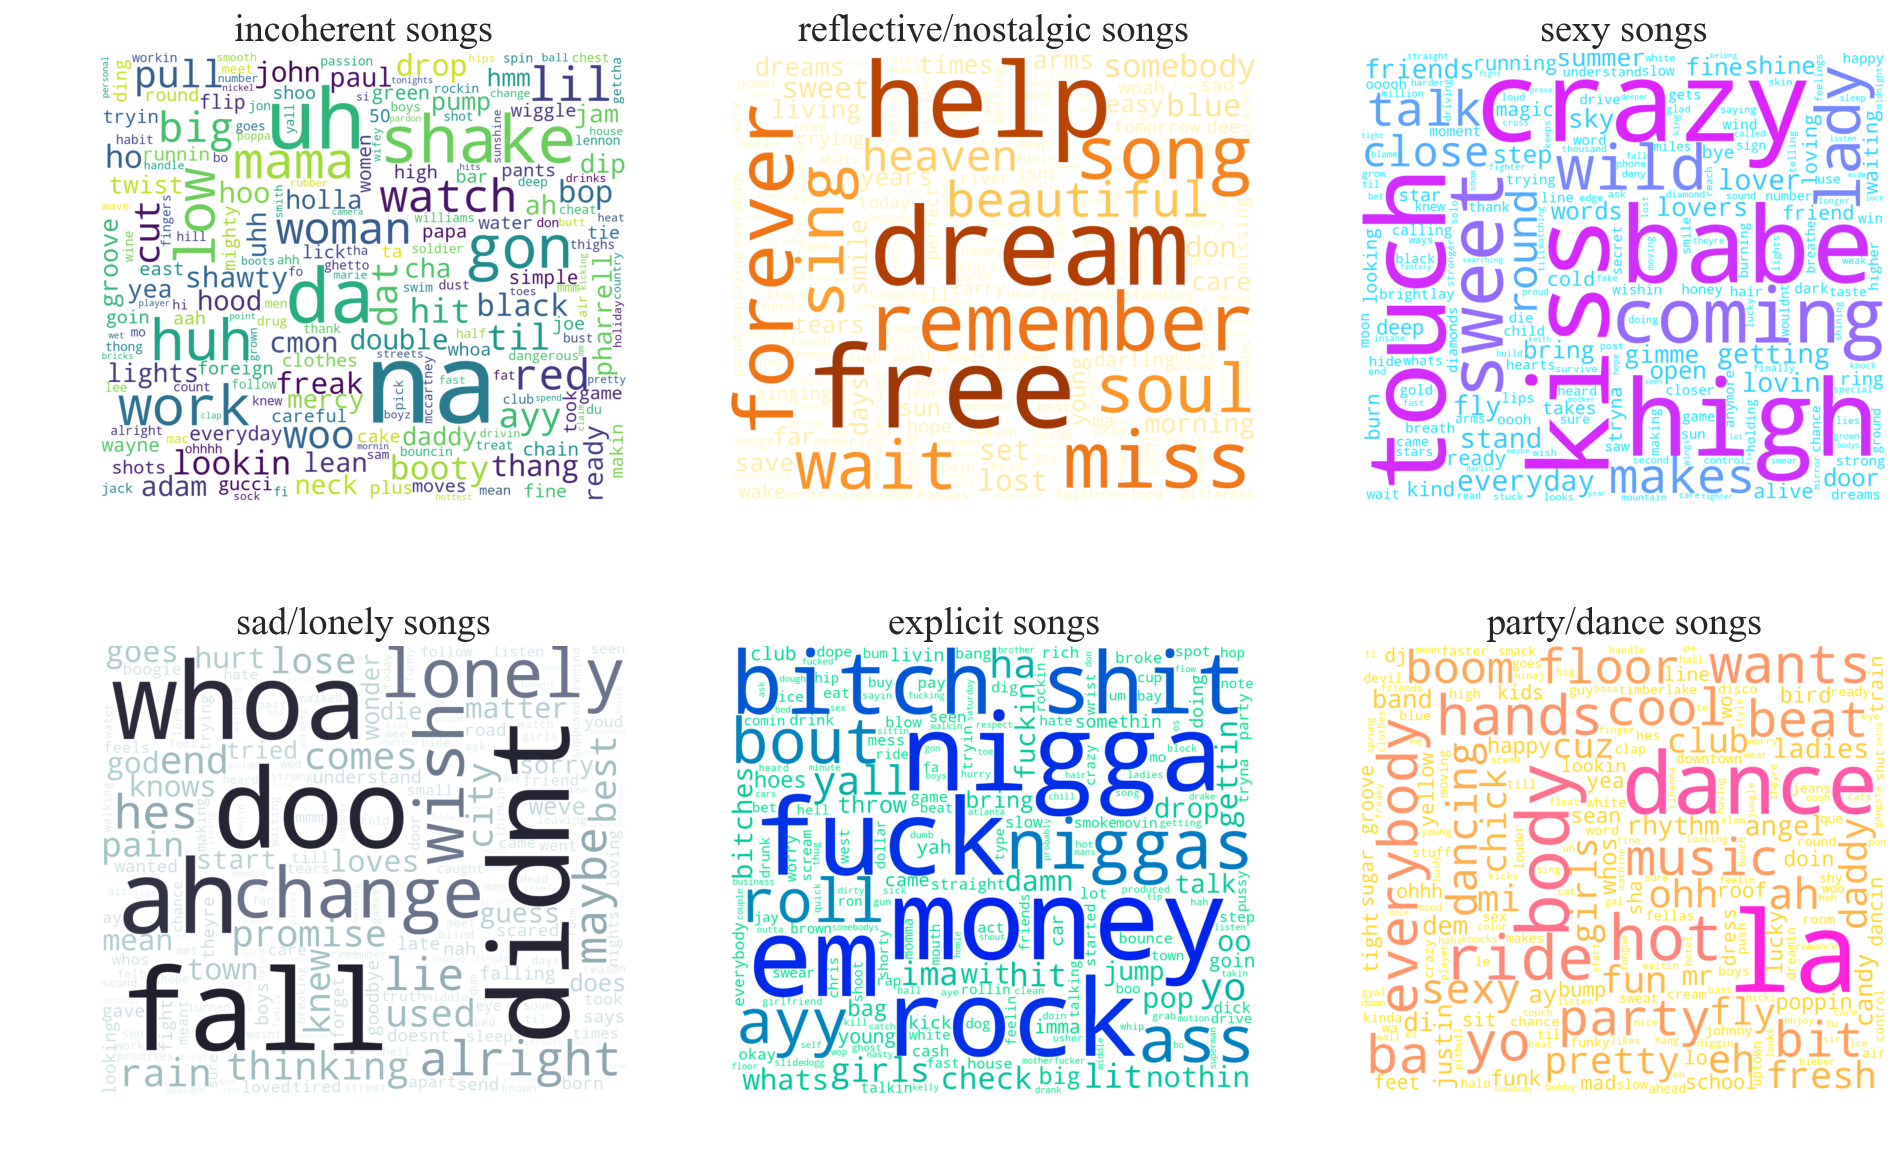

In [522]:
# convert lyrics to bag-of-words vectors
count = CountVectorizer(stop_words='english', min_df=10, max_df=500)
X_vect = count.fit_transform(np.array(lyrics))

# perform LDA and get the indices of top n_words_display words of each topic
n_topics = 6
n_words_display = 200
lda = LatentDirichletAllocation(n_topics=n_topics)
X_lda = lda.fit_transform(X_vect)
indices = (-lda.components_).argsort(axis=1)[:,:n_words_display]
vocab = np.array(count.get_feature_names())

# generate subplot axes
fig, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()

# plot word clouds
topics = ['incoherent songs', 'reflective/nostalgic songs', 'sexy songs',
          'sad/lonely songs', 'explicit songs', 'party/dance songs']
cmaps = ['rainbow', 'YlOrBr', 'cool', 'bone_r', 'winter_r', 'spring_r']
for i in range(n_topics):
    if i == 0:
        color_func = None
    else:
        color_func = colormap_size_func(cmaps[i], 350)
    weights = lda.components_[i][indices[i]]
    words = vocab[indices[i,:]]
    dictionary = dict(zip(words, weights))
    wordcloud = WordCloud(background_color='white', height=1200, min_font_size=5,
                      width=1400, color_func=color_func,
                      max_words=n_words_display, relative_scaling=0.5,
                      max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set(title=topics[i])